# Modelo de prediccion usando dataset sintetico

 Mediante el presente cuadernillo se hara el seguimiento paso a paso por el codigo y las decisiones tomadas para abordar este problema planteado para el primer parcial donde el objetivo es la prediccion de los indices de calidad del agua para el rio Quirpinchaca


### Definicion de librerias y modulos a utilizar en el proyecto

In [282]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

Generacion del dataset sintetico

In [283]:
def generate_time_series(batch_size, n_steps, add_trend=False, noise_type="normal", add_seasonality=True, add_outliers=False, make_stationary=False, add_lags=True):
    # Generate random frequencies and offsets for the sine waves
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    # Define the time series length
    time = np.linspace(0, 1, n_steps)
    
    # Create the series with a combination of sine waves and noise
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # Wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # Wave 2
    
    # Add noise based on the chosen noise type
    if noise_type == "normal":
        series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    elif noise_type == "poisson":
        series += 0.1 * np.random.poisson(1, (batch_size, n_steps))
    
    # Optionally add a trend to the data
    if add_trend:
        trend = np.linspace(0, 1, n_steps)
        series += 0.1 * trend
    
    # Optionally add seasonality to the data
    if add_seasonality:
        seasonality_period = np.random.randint(10, 20)
        series += 0.1 * np.sin(2 * np.pi * seasonality_period * time)
    
    # Optionally add outliers to the data
    if add_outliers:
        # Add random outliers to the series
        outlier_indices = np.random.choice(n_steps, size=int(0.05 * n_steps), replace=False)
        series[:, outlier_indices] += np.random.normal(0, 1, size=(batch_size, len(outlier_indices)))
    
    # Optionally make the data stationary
    if make_stationary:
        series = np.diff(series, axis=1)
    
    # Convert to desired format and add extra dimension
    series = series[..., np.newaxis].astype(np.float32)
    
    # Optionally add lagged features to the data
    if add_lags:
        lags = [1, 2, 3]
        for lag in lags:
            lagged_data = np.roll(series, lag, axis=1)
            lagged_data[:, :lag] = 0  # Set the first 'lag' values to zero
            series = np.concatenate((series, lagged_data), axis=-1)
    
    return series

In [284]:
# Parameters
n_steps = 50
batch_size = 10000

# Generate synthetic time series with additional options
series = generate_time_series(batch_size, n_steps + 1, add_trend=True, noise_type="normal", add_seasonality=True, add_outliers=True, make_stationary=True, add_lags=True)

# Split the data into training, validation, and test sets
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

# Check the shapes of the training data
X_train.shape, y_train.shape

((7000, 50, 8), (7000, 8))

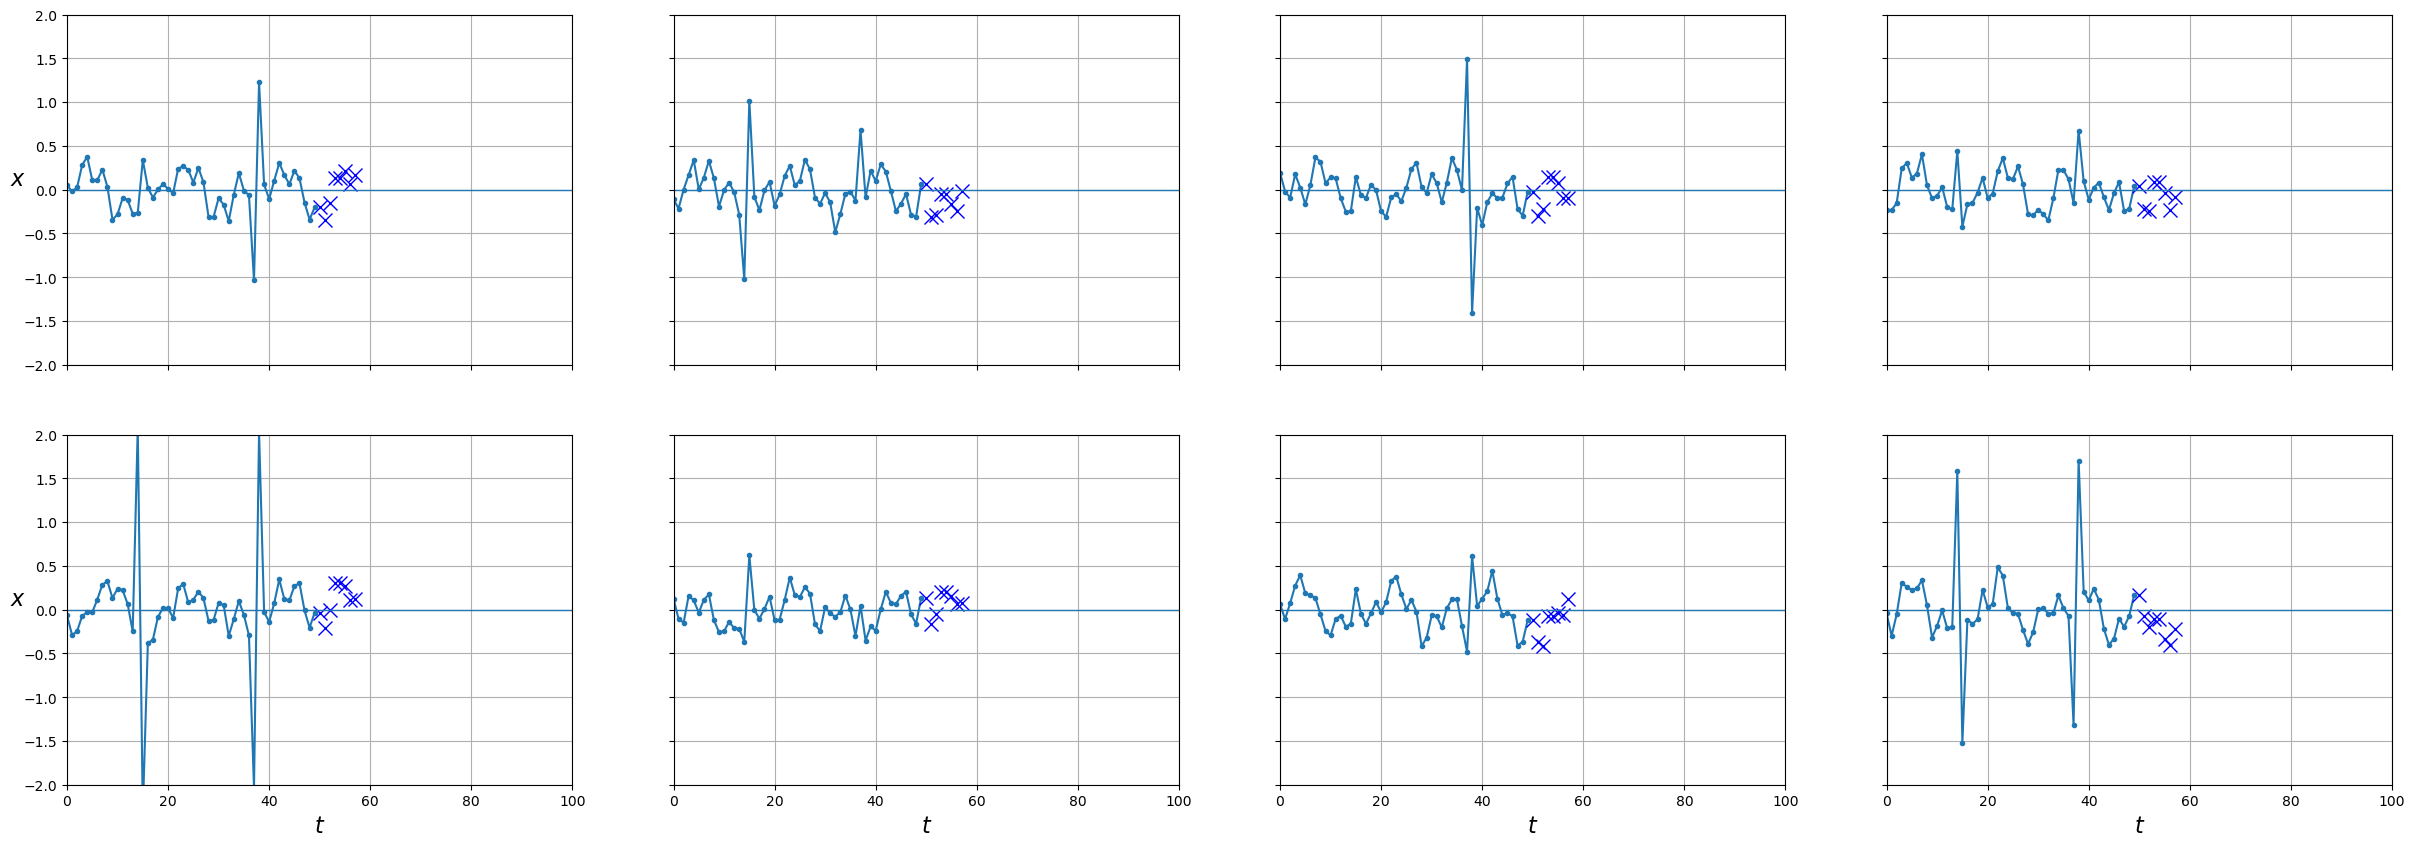

In [285]:
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    # Number of rows and columns for the grid
    r, c = 2, 4
    
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(30, 10))  # Increase the width from 20 to 30
    
    # Iterate through the rows and columns of the grid
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])  # Select the current subplot
            ix = col + row * c  # Calculate the index of the current series
            
            # Plot the series
            plt.plot(series[ix, :, 0], ".-", label="Series")
            
            # Plot the target values (y) if provided
            if y is not None:
                plt.plot(range(len(series[ix, :, 0]), len(series[ix, :, 0]) + len(y[ix])), y[ix], "bx", markersize=10, label="Target")
            
            # Plot the predicted values (y_pred) if provided
            if y_pred is not None:
                plt.plot(range(len(series[ix, :, 0]), len(series[ix, :, 0]) + len(y_pred[ix])), y_pred[ix], "ro", label="Prediction")
            
            # Plot the standard deviation of predictions (y_pred_std) if provided
            if y_pred_std is not None:
                plt.fill_between(
                    range(len(series[ix, :, 0]), len(series[ix, :, 0]) + len(y_pred[ix])),
                    y_pred[ix] - y_pred_std[ix],
                    y_pred[ix] + y_pred_std[ix],
                    color='gray', alpha=0.2, label="Std Dev"
                )
            
            # Add grid lines and set axis limits
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, 100, -2, 2])  # Adjust the range of x-axis and y-axis
            
            # Set x-axis label on the bottom row
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            
            # Set y-axis label on the leftmost column
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)
    
    # Display the plot
    plt.show()

# Plot the test series and the corresponding target values
plot_series(X_test, y_test)

In [286]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        # Initialize the dataset with input data X and optional target data y
        self.X = X
        self.y = y
        self.train = train

    def __len__(self):
        # Return the length of the dataset (number of samples)
        return len(self.X)

    def __getitem__(self, ix):
        # Fetch the input data for the given index ix
        x_data = torch.from_numpy(self.X[ix])
        
        # Fetch the target data if available (for training and validation)
        if self.train and self.y is not None:
            y_data = torch.from_numpy(self.y[ix])
            return x_data, y_data
        
        # Return only input data if not training (e.g., for testing)
        return x_data

# Create datasets for training, validation, and testing
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

# Create data loaders for each dataset
dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [287]:
class RNN(torch.nn.Module):
    def __init__(self, input_size=8, hidden_size=20, num_layers=1, output_size=8):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        last_output = x[:, -1, :]
        y = self.fc(last_output)
        return y
rnn = RNN()

In [288]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

def predict(model, dataloader):
    model.eval() 
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds


In [289]:
fit(rnn, dataloader)

loss 0.00012 loss_last_step 0.00006 val_loss 0.00009 val_loss_last_step 0.00005: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


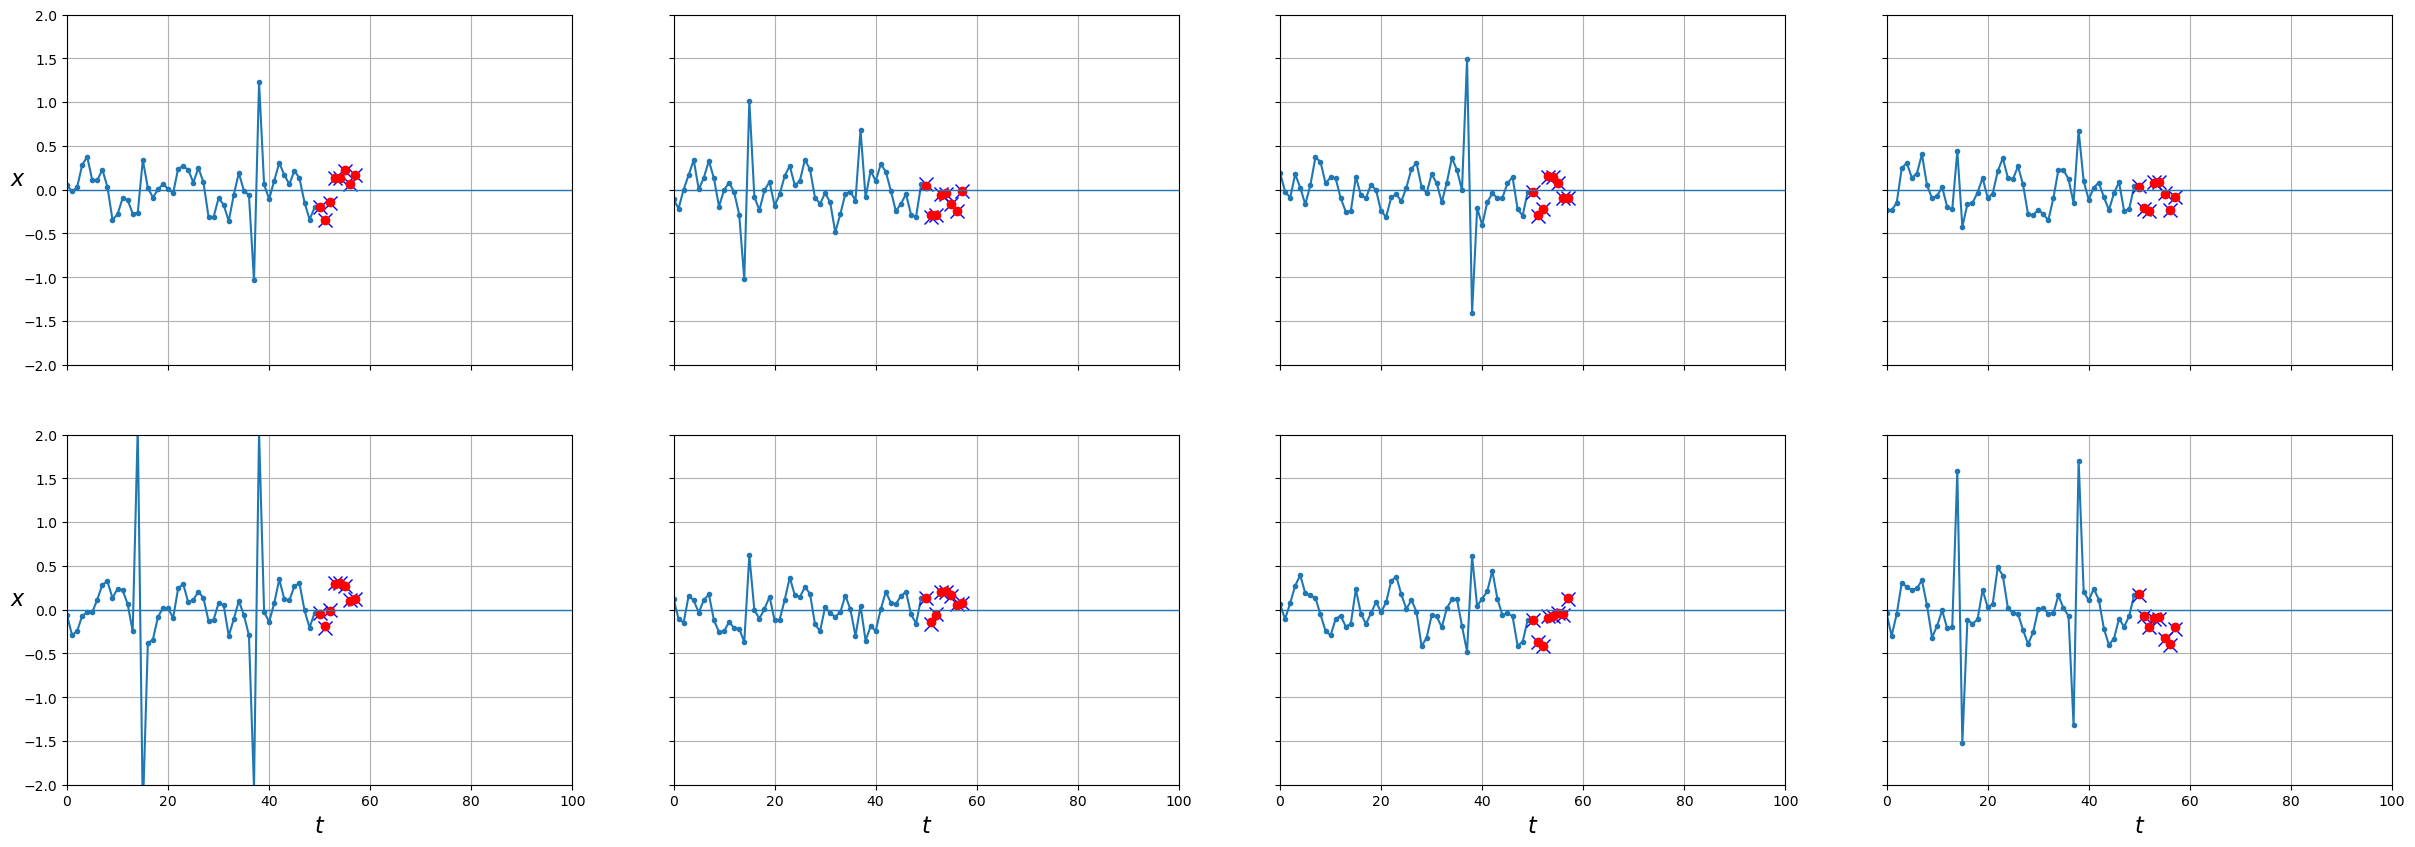

9.0105954e-05

In [290]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())


In [456]:
n_steps = 50
series = generate_time_series(10000, n_steps + 40)
X_train, y_train = series[:7000, :n_steps], series[:7000, -40:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -40:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -40:, 0]

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=128),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=128),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=128)
}

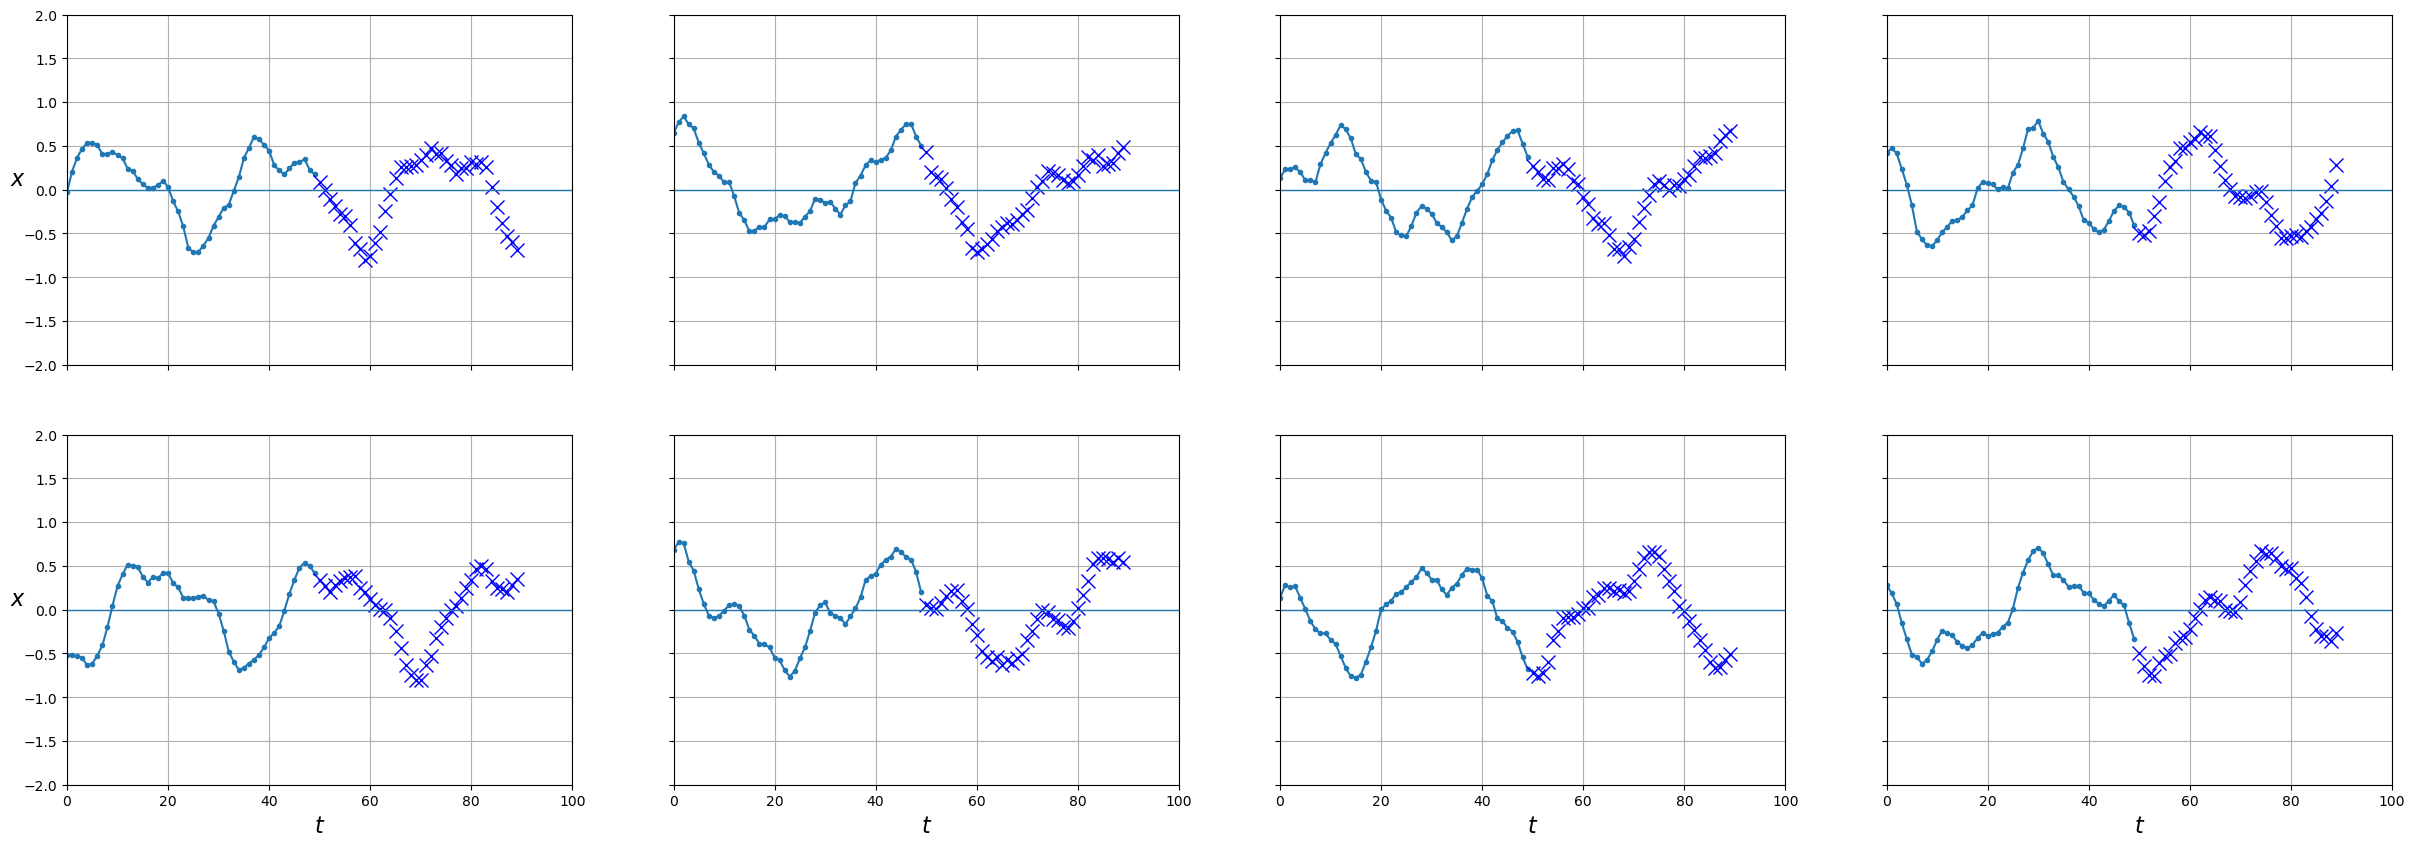

In [457]:
plot_series(X_test, y_test)

In [458]:
class DeepRNN(torch.nn.Module):
    def __init__(self, input_size=8, hidden_size=35, num_layers=4, output_size=40):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        x_reshaped = x[:, -1, :].contiguous().view(-1, x.size(-1))
        y = self.fc(x_reshaped)
        y = y.contiguous().view(x.size(0), -1)
        return y
    
rnn = DeepRNN()

In [459]:
fit(rnn, dataloader)

loss 0.03481 loss_last_step 0.05393 val_loss 0.03134 val_loss_last_step 0.04807: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


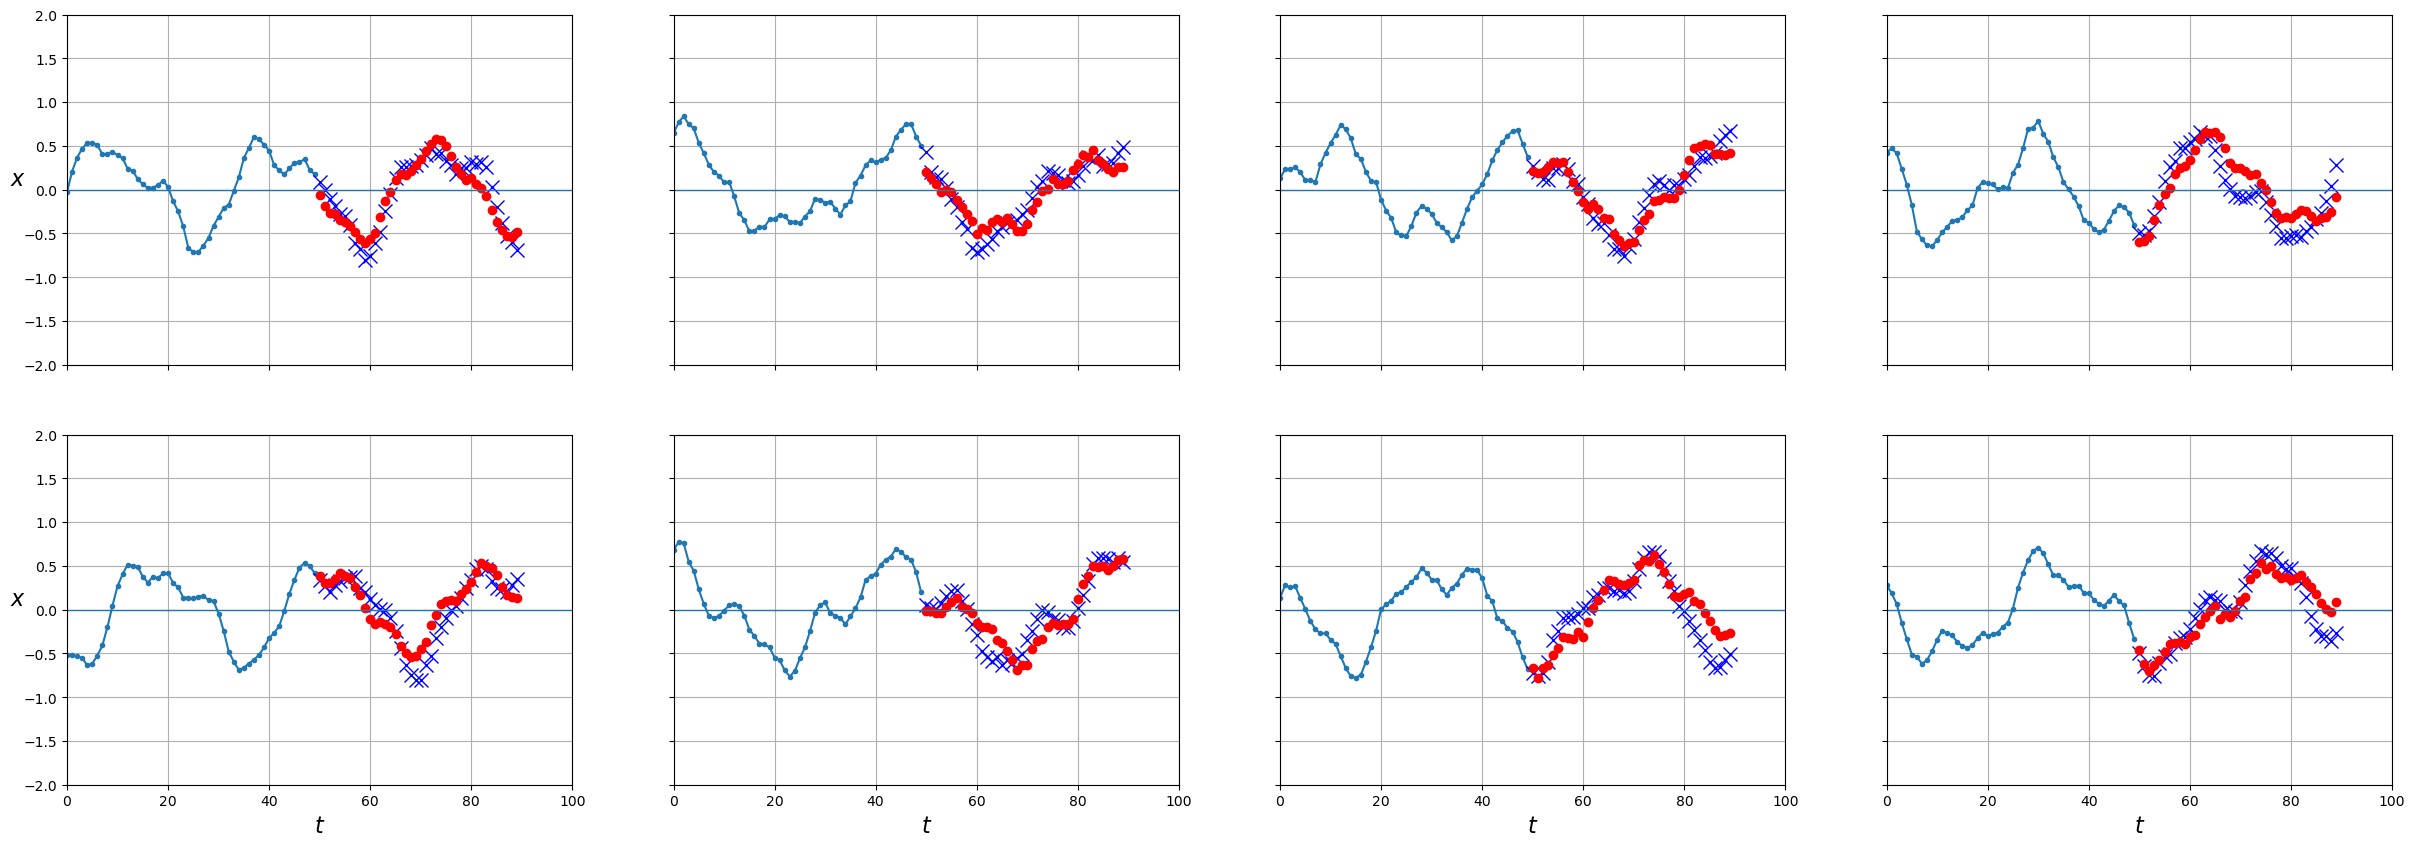

0.031534404

In [460]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())
